In [247]:
import os
import pandas as pd
import numpy as np
import sys
import seaborn as sns
from sklearn.utils import shuffle

%matplotlib inline

In [248]:
head = [
    'Page Popularity', 
    'Page Checkins',
    'Page talking about',
    'Page Category'    
] + ['extra_{}'.format(i - 4) for i in range(4, 29)] + \
[
    'CC1',
    'CC2',
    'CC3',
    'CC4',
    'CC5',
    'Base Time',
    'Post Length',
    'Post Share Count',
    'Post Promotion Status',
    'H Local'
] + ['published_weekday_{}'.format(i - 39) for i in range(39, 46)] + ['base_weekday_{}'.format(i-45) for i in range(45, 52)] + ['Target']

In [249]:
train_dataset_small = pd.read_csv('./Training/Features_Variant_1.csv', names=head)

\begin{array}{rcl} \frac{\partial \mathcal{L}}{\partial \vec{w}} &=& \frac{\partial}{\partial \vec{w}} \frac{1}{2n} \left( \vec{y}^T \vec{y} -2\vec{y}^T X \vec{w} + \vec{w}^T X^T X \vec{w}\right) \\ &=& \frac{1}{2n} \left(-2 X^T \vec{y} + 2X^T X \vec{w}\right) \end{array}

In [250]:
def RMSE_score(y_pred, y_real):
    return np.sqrt(np.sum(np.power(y_pred - y_real, 2)) / y_pred.shape[0])

def R2_score(y_pred, y_real):
    return 1 - np.sum(np.power(y_pred - y_real, 2)) / np.sum(np.power(y_real - np.mean(y_real), 2))

def R2_adj_score(y_pred, y_real, features):
    R2 = R2_score(y_pred, y_real)
    return 1 - (1 - R2) * (y_real.shape[0] - 1) / (y_real.shape[0] - features - 1)

class LinearModel(object):
    def __init__(self, epochs=5, use_constant=True, epsilon=1e-5, step=0.001):
        self.use_constant = use_constant
        #self.batches = batches
        self.epochs = epochs
        self.epsilon = epsilon
        self.step = step
        self.w = None
    
    def fit(self, X, y):
        if self.use_constant:
            self.w = np.random.normal(size=X.shape[1] + 1, scale=0.1)
            X = np.hstack([X, np.array([1] * X.shape[0]).reshape(-1, 1)])
        else:
            self.w = np.random.normal(size=X.shape[1])
        
        #n = X.shape[0]
        #batch_size = n // self.batches
        
        for epoch in range(1, self.epochs + 1):
            X, y = shuffle(X, y)
            prev_w = np.copy(self.w)
            
            dw = X.T.dot(X).dot(self.w) - X.T.dot(y)
            self.w = self.w - dw * self.step / np.log2(epoch + 1)
            #for batch in range(self.batches):
            #    X_batch = X[batch * batch_size:(batch+1) * batch_size]
            #    y_batch = y[batch * batch_size:(batch+1) * batch_size]
            # 
            #    dw = X_batch.T.dot(X_batch).dot(self.w) - X_batch.T.dot(y_batch)
            #    self.w = self.w - dw * .0001 / np.log2(epoch + 1)
            
            if np.linalg.norm(self.w - prev_w) < self.epsilon:
                return
                
            
    
    def predict(self, X, y=None):
        if self.use_constant:
            X = np.hstack([X, np.array([1] * X.shape[0]).reshape(-1, 1)])
        return X.dot(self.w)

# функции для определения типа переменных

In [251]:
def is_float(x):
    return (x - x.astype(int)).abs().sum() > 0

def is_binary(x):
    return x.unique().shape[0] == 2

def is_unary(x):
    return x.unique().shape[0] == 1

# определение типа переменных и трансформации

In [252]:
pd.DataFrame({
    'вещественная': train_dataset_small.apply(is_float, axis=0), 
    'бинарная': train_dataset_small.apply(is_binary, axis=0),
    'константная': train_dataset_small.apply(is_unary, axis=0)
})

,вещественная,бинарная,константная
Page Popularity,False,False,False
Page Checkins,False,False,False
Page talking about,False,False,False
Page Category,False,False,False
extra_0,False,False,False
extra_1,False,False,False
extra_2,True,False,False
extra_3,True,False,False
extra_4,True,False,False
extra_5,False,False,False


# делаем копию датасета

In [253]:
from copy import deepcopy as copy
from matplotlib import pyplot

train_dataset_small_new = copy(train_dataset_small).dropna()

# тестируем на грязных данных

In [254]:
X = train_dataset_small_new
y = train_dataset_small_new.Target
X = X.drop('Target', axis=1)
X = X.drop('Post Promotion Status', axis=1)

In [255]:
# получаем список не-бинарных переменных
not_binary_cols = X.columns[~X.apply(is_binary)]
print(not_binary_cols)
# выполняем нормировку не-биинарных переменных
X[not_binary_cols] = X[not_binary_cols].apply(lambda x: (x - x.mean()) / (x.std()), axis=0)

Index(['Page Popularity', 'Page Checkins', 'Page talking about',
       'Page Category', 'extra_0', 'extra_1', 'extra_2', 'extra_3', 'extra_4',
       'extra_5', 'extra_6', 'extra_7', 'extra_8', 'extra_9', 'extra_10',
       'extra_11', 'extra_12', 'extra_13', 'extra_14', 'extra_15', 'extra_16',
       'extra_17', 'extra_18', 'extra_19', 'extra_20', 'extra_21', 'extra_22',
       'extra_23', 'extra_24', 'CC1', 'CC2', 'CC3', 'CC4', 'CC5', 'Base Time',
       'Post Length', 'Post Share Count', 'H Local'],
      dtype='object')


In [256]:
rmse_train = []
rmse_test = []
r2_train = []
r2_test = []
r2_adj_train = []
r2_adj_test = []
features = []
features_names = []

for ix_train, ix_test in get_folds(X, 5):
    mdl = LinearModel(epochs=200, epsilon=1e-6, step=0.00001)
    
    X_train = X.iloc[ix_train]
    y_train = y.iloc[ix_train]
    
    X_test = X.iloc[ix_test]
    y_test = y.iloc[ix_test]
    
    #valid_index = np.where((y_train > y_train.quantile(0.02)) & (y_train < y_train.quantile(0.98)))
    #print(valid_index)
    #X_train = X_train[(y_train > y_train.quantile(0.02)) & (y_train < y_train.quantile(0.98))]
    #y_train = y_train[(y_train > y_train.quantile(0.02)) & (y_train < y_train.quantile(0.98))]
    
    mdl.fit(X_train, y_train)
    
    rmse_test.append(RMSE_score(mdl.predict(X_test), y_test))
    r2_test.append(R2_score(mdl.predict(X_test), y_test))
    r2_adj_test.append(R2_adj_score(mdl.predict(X_test), y_test, X.columns.shape[0]))
    
    rmse_train.append(RMSE_score(mdl.predict(X_train), y_train))
    r2_train.append(R2_score(mdl.predict(X_train), y_train))
    r2_adj_train.append(R2_adj_score(mdl.predict(X_train), y_train, X.columns.shape[0]))
    
    
    #temp = sorted(zip(X.columns, mdl.w), key=lambda x: -np.abs(x[1]))
    features.append(mdl.w)
    #features_names.append([i[0] for i in temp])

In [257]:
df = pd.DataFrame(np.vstack([r2_test, r2_train, r2_adj_test, r2_adj_train, rmse_test, rmse_train, np.array(features).T]), index=[
    'r2_test',
    'r2_train',
    'r2_adj_test',
    'r2_adj_train',
    'rmse_test',
    'rmse_train',
] + ['constant'] + X.columns.tolist())

df = pd.concat([df, df.mean(axis=1).rename('mean'), df.std(axis=1).rename('std')], axis=1)

df

,0,1,2,3,4,mean,std
r2_test,0.374031,0.289252,0.320900,-0.085508,0.328779,0.245491,0.187497
r2_train,0.297708,0.327106,0.319189,0.355997,0.318652,0.323730,0.021072
r2_adj_test,0.370030,0.284709,0.316559,-0.092445,0.324489,0.240668,0.188696
r2_adj_train,0.296591,0.326036,0.318106,0.354973,0.317569,0.322655,0.021105
rmse_test,31.383742,29.391817,31.524414,37.200018,22.652267,30.430452,5.232386
rmse_train,28.782271,29.243520,28.687630,28.440355,30.701154,29.170986,0.903497
constant,-0.190923,0.247689,0.275699,0.073839,0.448732,0.171007,0.242078
Page Popularity,-0.626736,-0.555534,-0.471985,-1.060674,-0.164697,-0.575925,0.323222
Page Checkins,-1.213085,-1.593789,-1.494219,-0.654041,-2.338966,-1.458820,0.612818
Page talking about,-0.029072,0.013639,-0.176568,-0.181203,-0.040649,-0.082771,0.090055


# новая копия датасета

In [258]:
from copy import deepcopy as copy
from matplotlib import pyplot

train_dataset_small_new = copy(train_dataset_small).dropna()

# удаляем лишние переменные

In [259]:
# удаляем лишний параметр для устранения мультиколлинеарности
train_dataset_small_new = train_dataset_small_new.drop(['published_weekday_0', 'base_weekday_0'], axis=1)

In [260]:
train_dataset_small_new = train_dataset_small_new.drop(['Post Promotion Status'], axis=1)

In [261]:
# меняем категориальную переменную на дамми-переменные
train_dataset_small_new = train_dataset_small_new.drop('Page Category', axis=1)
Page_Category = pd.get_dummies(train_dataset_small['Page Category'])
Page_Category = Page_Category.rename(columns={x: 'Page_Category_%d' % x for x in Page_Category.columns})
train_dataset_small_new = pd.concat([train_dataset_small_new, Page_Category], axis=1)

# проверяем, какие из экстра фичей коррелируют друг с другом

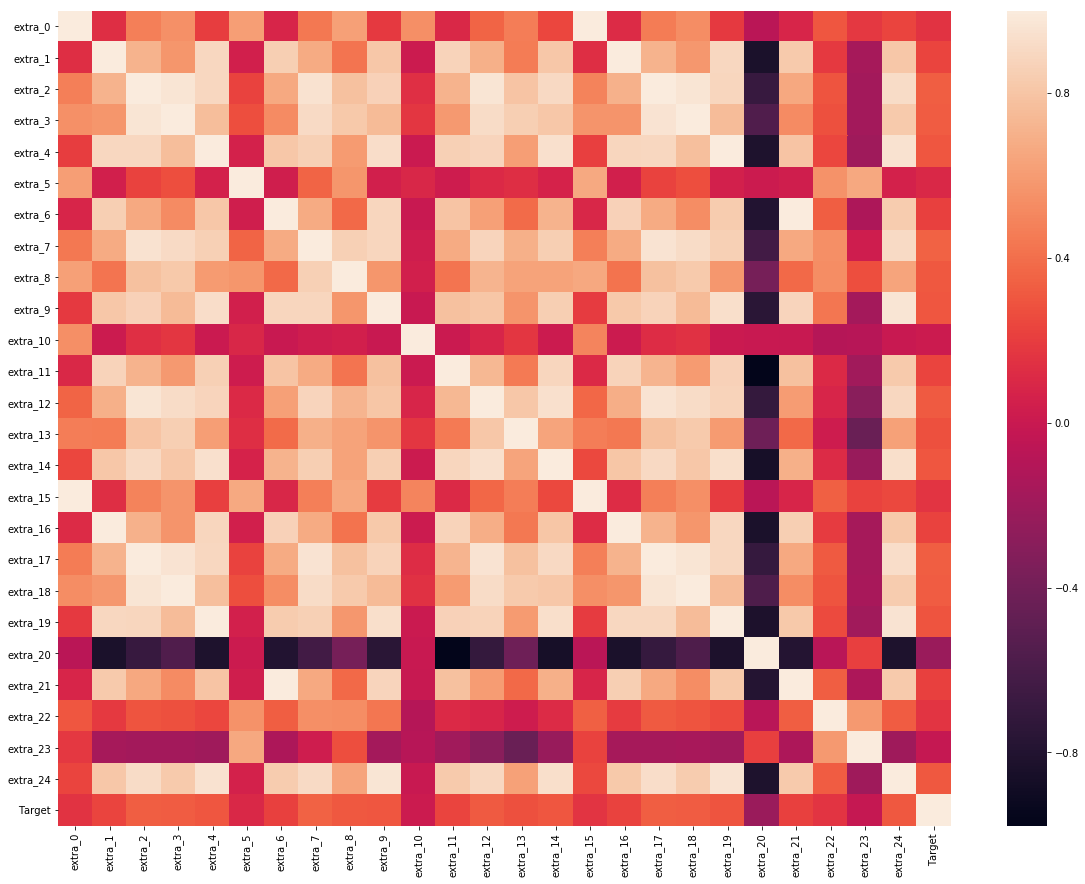

In [262]:
pyplot.figure(figsize=(20, 15))
sns.heatmap(train_dataset_small_new[['extra_{}'.format(i) for i in range(0, 25)] + ['Target']].corr())

In [263]:
# удаляем почти все переменные
train_dataset_small_new = train_dataset_small_new.drop(['extra_20', 'extra_23', 'extra_24', 'extra_21', 'extra_0','extra_8', 'extra_19', 'extra_18', 'extra_17', 'extra_9', 'extra_4', 'extra_14',
      'extra_12',  'extra_1', 'extra_6','extra_7', 'extra_2', 'extra_11', 'extra_16', 'extra_15', 'extra_5', 'extra_10', 'extra_13'], axis=1)

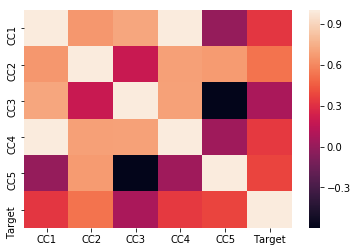

In [264]:
sns.heatmap(train_dataset_small[['CC1', 'CC2', 'CC3', 'CC4', 'CC5', 'Target']].corr())


In [265]:
# удаляем часть переменных
train_dataset_small_new = train_dataset_small_new.drop(['CC1', 'CC3', 'CC4',], axis=1)

In [266]:
# удаляем переменную Base Time, поскольку для нее сложно придумать адекватное представление

#train_dataset_small_new = train_dataset_small_new.drop('Base Time', axis=1)

In [267]:
#train_dataset_small_new = train_dataset_small_new.drop('Page talking about', axis=1)

In [268]:
# дамми кодинг переменной "время"

train_dataset_small_new = train_dataset_small_new.drop('H Local', axis=1)

HLocal = pd.get_dummies(train_dataset_small['H Local'])
HLocal = HLocal.rename(columns={x: 'H_Local_%d' % x for x in HLocal.columns})

train_dataset_small_new = pd.concat([train_dataset_small_new, HLocal], axis=1)

In [269]:
X = copy(train_dataset_small_new).dropna()

In [270]:
y = X['Target']
X = X.drop('Target', axis=1)

In [271]:
X, y = shuffle(X, y)

In [272]:
# получаем список не-бинарных переменных
not_binary_cols = X.columns[~X.apply(is_binary)]
print(not_binary_cols)
# выполняем нормировку не-биинарных переменных
X[not_binary_cols] = X[not_binary_cols].apply(lambda x: (x - x.mean()) / (x.std()), axis=0)

Index(['Page Popularity', 'Page Checkins', 'Page talking about', 'extra_3',
       'extra_22', 'CC2', 'CC5', 'Base Time', 'Post Length',
       'Post Share Count'],
      dtype='object')


In [273]:
def get_folds(X, batches=8):
    indices = list(range(X.shape[0]))
    batch_size = X.shape[0] // batches
    for batch in range(batches):
        test = indices[batch_size*batch:batch_size*(batch+1)]
        if batch:
            train = indices[:batch_size*batch] + indices[batch_size*(batch+1):]
        else:
            train = indices[batch_size*(batch+1):]
            
        yield (train, test)

In [274]:
rmse_train = []
rmse_test = []
r2_train = []
r2_test = []
r2_adj_train = []
r2_adj_test = []
features = []
features_names = []

for ix_train, ix_test in get_folds(X, 5):
    mdl = LinearModel(epochs=100, epsilon=1e-5, step=0.0001)
    
    X_train = X.iloc[ix_train]
    y_train = y.iloc[ix_train]
    
    X_test = X.iloc[ix_test]
    y_test = y.iloc[ix_test]
    
    #valid_index = np.where((y_train > y_train.quantile(0.02)) & (y_train < y_train.quantile(0.98)))
    #print(valid_index)
    X_train = X_train[(y_train > y_train.quantile(0.01)) & (y_train < y_train.quantile(0.99))]
    y_train = y_train[(y_train > y_train.quantile(0.01)) & (y_train < y_train.quantile(0.99))]
    
    mdl.fit(X_train, y_train)
    
    rmse_test.append(RMSE_score(mdl.predict(X_test), y_test))
    r2_test.append(R2_score(mdl.predict(X_test), y_test))
    r2_adj_test.append(R2_adj_score(mdl.predict(X_test), y_test, X.columns.shape[0]))
    
    rmse_train.append(RMSE_score(mdl.predict(X_train), y_train))
    r2_train.append(R2_score(mdl.predict(X_train), y_train))
    r2_adj_train.append(R2_adj_score(mdl.predict(X_train), y_train, X.columns.shape[0]))
    
    
    #temp = sorted(zip(X.columns, mdl.w), key=lambda x: -np.abs(x[1]))
    features.append(mdl.w)

In [275]:
df = pd.DataFrame(np.vstack([r2_test, r2_train, r2_adj_test, r2_adj_train, rmse_test, rmse_train, np.array(features).T]), index=[
    'r2_test',
    'r2_train',
    'r2_adj_test',
    'r2_adj_train',
    'rmse_test',
    'rmse_train',
] + ['constant'] + X.columns.tolist())# + ['f%d' % i for i in range(1, 6)], columns=['T%d' % i for i in range(1, 6)])

df = pd.concat([df, df.mean(axis=1).rename('mean'), df.std(axis=1).rename('std')], axis=1)

df

,0,1,2,3,4,mean,std
r2_test,0.255597,0.227399,0.210985,0.306867,0.257466,0.251663,0.036538
r2_train,0.430342,0.436266,0.425028,0.422942,0.435515,0.430019,0.006007
r2_adj_test,0.243869,0.215227,0.198555,0.295947,0.245768,0.239873,0.037113
r2_adj_train,0.425253,0.431228,0.419911,0.417805,0.430478,0.424935,0.006052
rmse_test,27.943975,34.070488,34.601515,25.778067,30.731597,30.625128,3.820212
rmse_train,14.145406,14.089876,14.047060,13.804990,13.793801,13.976227,0.165194
constant,1.001541,0.819746,0.555986,0.805070,0.966849,0.829838,0.176043
Page Popularity,-0.061649,-0.293758,-0.265432,-0.088070,-0.152498,-0.172282,0.103870
Page Checkins,0.460124,0.508506,0.578942,0.456256,0.454347,0.491635,0.053718
Page talking about,2.227781,1.976036,2.125055,1.952235,2.049724,2.066166,0.112873


In [276]:
# мини на фуллбатч (+), построить на плохих данных (+), вывести все фичи (+), тесты с аутлаерами (+)